# Convert Atlas dataset into Oceantide format

In [1]:
import itertools
import warnings
from pathlib import Path
import datetime
import pandas as pd
import xarray as xr

from oceantide import read_otis_atlas_netcdf, read_oceantide

warnings.filterwarnings("ignore", category=RuntimeWarning) 


In [2]:
def chunked_iterable(iterable, size):
    """Iterate through array over chunks with specific size."""
    it = iter(iterable)
    while True:
        chunk = tuple(itertools.islice(it, size))
        if not chunk:
            break
        yield chunk

## Convert by iterating through longitudes over chunks of size 200 to handle memory
The Atlas dataset is very large. It is composed by one file per constituent for elevation and transports at 1/30 degree resolution. Reading in the full dataset into oceantide format cannot be handled unless available RAM is very large. Here we overcome this limitation by converting and concatenating longitude chunks at a time. 

In [3]:
atlas_path = Path("/data/tide/tpxo9v4_atlas/TPXO9_atlas_nc")

lons = xr.open_dataset(atlas_path / "grid_tpxo9_atlas_v4.nc").lon_z.values

chunksizes = 100
itersize = 200

for ind in chunked_iterable(range(lons.size), size=itersize):
    x0 = lons[ind[0]]
    x1 = lons[ind[-1]]
    # print(f"Writing lon chunk {ind[0]}")
    dset = read_otis_atlas_netcdf(atlas_path, x0=x0, x1=x1, nxchunk=itersize, nychunk=None)
    dset = dset.chunk({"con": None, "lon": chunksizes, "lat": chunksizes})
    if ind[0] == 0:
        mode = "w"
        append_dim = None
    else:
        mode = "a"
        append_dim = "lon"
    dset.to_zarr("./atlas.zarr", mode=mode, consolidated=True, append_dim=append_dim)


In [5]:
dset = read_oceantide("./atlas.zarr")
dset

<xarray.Dataset>
Dimensions:  (con: 14, lat: 5401, lon: 10800)
Coordinates:
  * con      (con) <U4 'M2' 'S2' 'N2' 'K2' 'K1' ... 'MF' 'M4' 'MN4' 'MS4' '2N2'
  * lat      (lat) float64 -90.0 -89.97 -89.93 -89.9 ... 89.9 89.93 89.97 90.0
  * lon      (lon) float64 0.03333 0.06667 0.1 0.1333 ... 359.9 360.0 360.0
Data variables:
    dep      (lat, lon) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    h        (con, lat, lon) complex128 dask.array<chunksize=(14, 100, 100), meta=np.ndarray>
    u        (con, lat, lon) complex128 dask.array<chunksize=(14, 100, 100), meta=np.ndarray>
    v        (con, lat, lon) complex128 dask.array<chunksize=(14, 100, 100), meta=np.ndarray>
Attributes:
    description:  Oceantide tidal constituents

## Check M2

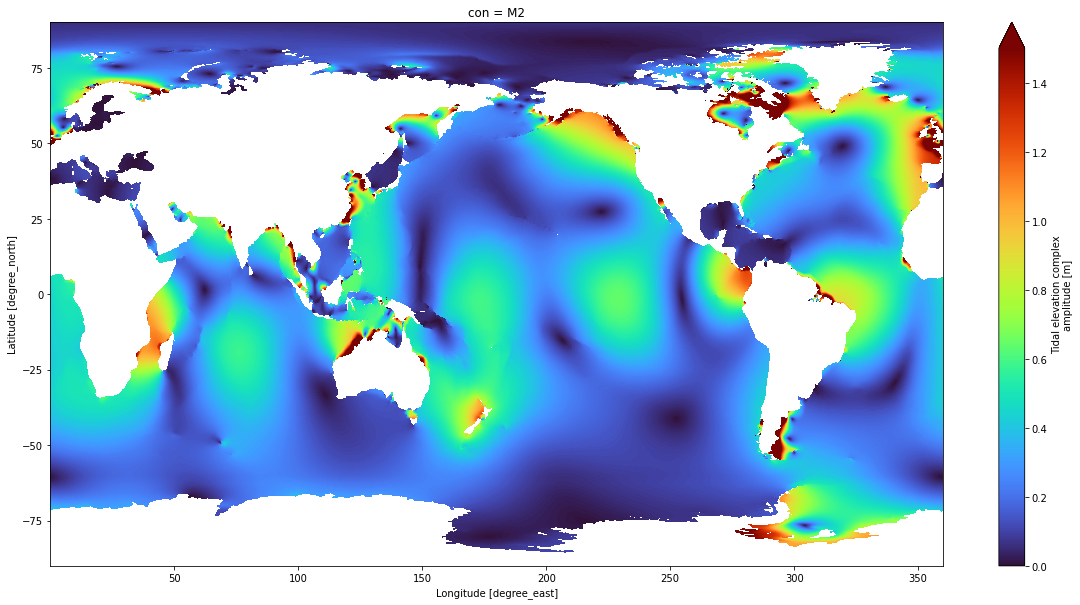

In [6]:
ds = dset.sel(con="M2").tide.amplitude("h")
ds = ds.load()
ds.plot(figsize=(20, 10), vmin=0, vmax=1.5, cmap="turbo");

## Calculate and plot 1-year timeseries at 15 min intervals

In [7]:
times = pd.date_range(
    start=datetime.datetime(2012,1,1),
    end=datetime.datetime(2013,1,1),
    freq="15MIN"
)
ds = dset.sel(lon=0, lat=50, method="nearest").tide.predict(times=times).load()
ds

<xarray.Dataset>
Dimensions:  (time: 35137)
Coordinates:
    lat      float64 50.0
    lon      float64 0.03333
  * time     (time) datetime64[ns] 2012-01-01 2012-01-01T00:15:00 ... 2013-01-01
Data variables:
    dep      float32 35.4
    h        (time) float64 -0.3153 -0.0824 0.1499 0.3785 ... 2.349 2.523 2.658
    u        (time) float64 -63.29 -74.32 -83.36 -90.11 ... 81.93 79.45 76.27
    v        (time) float64 -0.1645 -5.376 -10.46 -15.26 ... 12.47 13.34 14.16
Attributes:
    description:  Tide elevation and currents time series

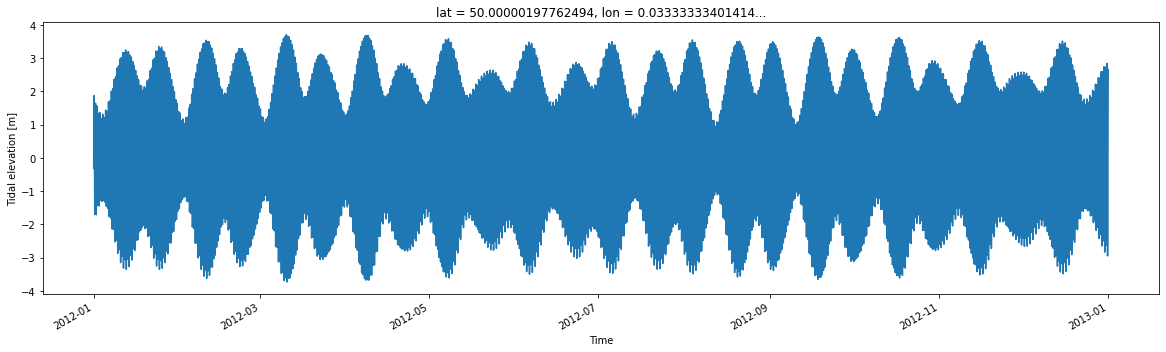

In [8]:
ds.h.plot(figsize=(20, 5));